In this notebook, we apply GMM-MI to a synthetic Gaussian mixture model, calculating the MI residuals over different realisations of the ground truth. We consider a dataset with 3 components, D3.

### Import packages

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from gmm_mi.mi import EstimateMI
from gmm_mi.param_holders import GMMFitParamHolder, SelectComponentsParamHolder, MIDistParamHolder
from gmm_mi.gmm import GMMWithMI as GMM
from gmm_mi.data.synthetic_data import D3_rhoneq0 as dataset
from gmm_mi.utils.plotting import plot_gmm_contours, plot_bias_chi2_histogram

### Calculate the true MI of the synthetic model, and plot contours

True MI: 0.148 nats


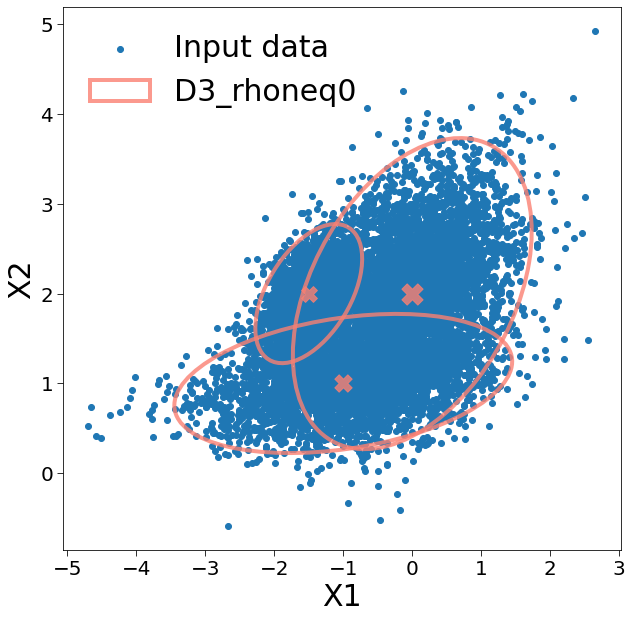

In [2]:
label = 'D3_rhoneq0'
analytic = np.load(f'./MI_synthetic_datasets/MI_{label}.npy')
print(f'True MI: {analytic:.3f} nats')
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
scatter_data = dataset.sample(1e4)[0]
ax.scatter(scatter_data[:, 0], scatter_data[:, 1], label='Input data')
fig, ax = plot_gmm_contours(dataset, ax=ax, label=label)

### Test on 501 trials

In [3]:
# all unspecified parameters are set to their default values

# parameters for every GMM fit that is being run
gmm_fit_params = GMMFitParamHolder(threshold_fit=1e-6,
                                   reg_covar=1e-12)

# parameters to choose the number of components
select_components_params = SelectComponentsParamHolder(n_inits=10,
                                                       n_folds=5)

# parameters for MI distribution estimation
mi_dist_params = MIDistParamHolder(n_bootstrap=100,
                                   MC_samples=1e5)

In [4]:
random_states = 501
N = 10000
results_file = f'./results/MI_{label}_{random_states}.npy'

if os.path.isfile(results_file) :
    print('Not running this cell, since results file already exists. '
          'Loading pre-computed results...')
    all_MI_estimates = np.load(results_file)
else:
    print(f'Estimating MI, and saving results...')
    all_MI_estimates = np.zeros((random_states, 2))

    # true GMM parameters
    n_components = dataset.n_components 
    true_weights = dataset.weights_
    true_means = dataset.means_
    true_covariances = dataset.covariances_
    
    for r in range(random_states):
        # create different realisation of ground truth; note the different random_state each time
        X = GMM(n_components=n_components, weights_init=true_weights, 
                          means_init=true_means, covariances_init=true_covariances, 
                          random_state=r).sample(N)[0]  
            
        mi_estimator = EstimateMI(gmm_fit_params=gmm_fit_params,
                                  select_components_params=select_components_params,
                                  mi_dist_params=mi_dist_params)
        MI_mean, MI_std = mi_estimator.fit(X)   
            
        all_MI_estimates[r, 0] = MI_mean
        all_MI_estimates[r, 1] = MI_std

        np.save(results_file, all_MI_estimates)

Not running this cell, since results file already exists. Loading pre-computed results...


### Evaluate MI bias

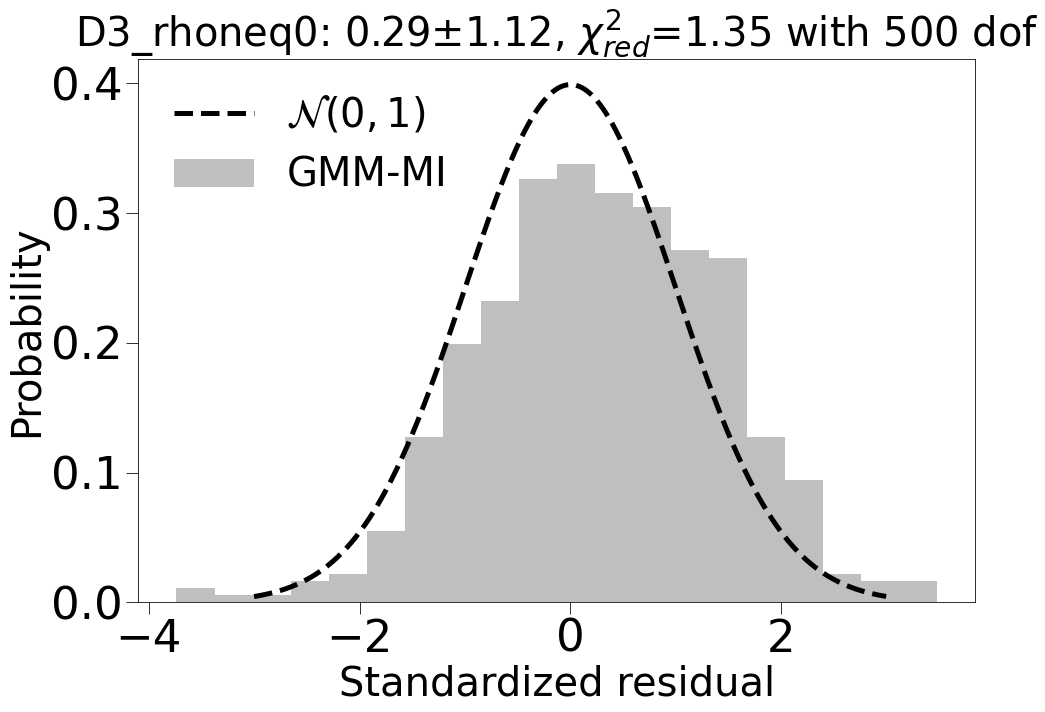

In [5]:
show_title=True
show_legend=True
hide_ylabel=False
labelfontsize=40
legendsize=40

biases, red_chi2, df = plot_bias_chi2_histogram(all_MI_estimates, analytic=analytic, 
                                                show_title=show_title, show_legend=show_legend, 
                                                hide_ylabel=hide_ylabel, labelfontsize=labelfontsize, 
                                                ds=label, legendsize=legendsize)

### Paper figure

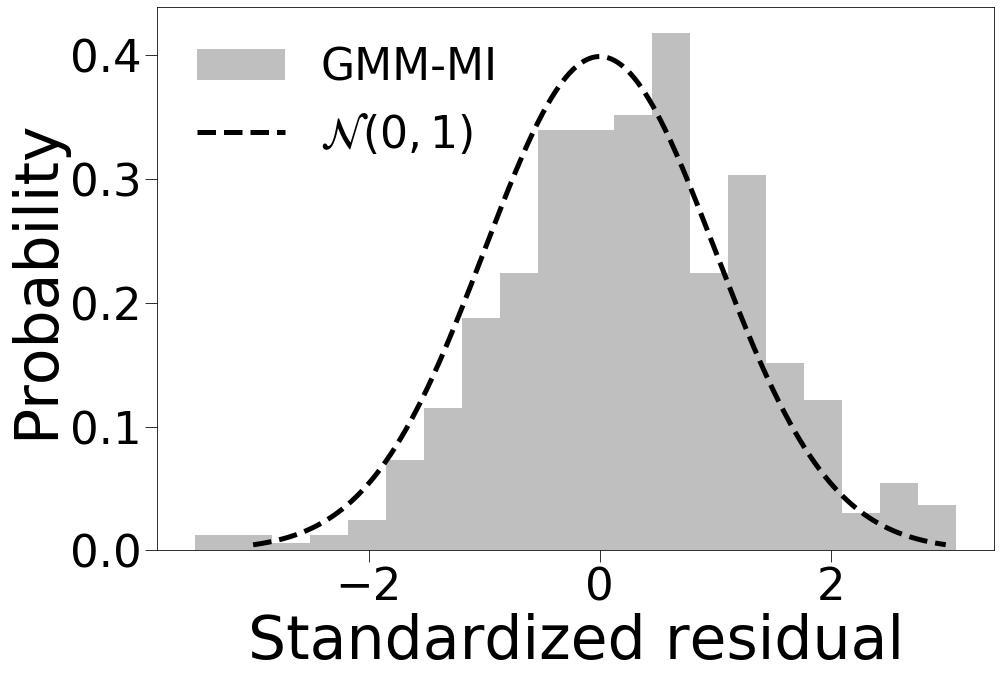

In [6]:
show_title=False
show_legend=True
hide_ylabel=False
savefig=True
savepath=f'./figures/{label}_residuals.pdf'

biases, red_chi2, df = plot_bias_chi2_histogram(all_MI_estimates, analytic=analytic, 
                                                show_title=show_title, show_legend=show_legend, 
                                                hide_ylabel=hide_ylabel, ds=label, 
                                                savefig=savefig, savepath=savepath)

### Plot histogram of bias and variance

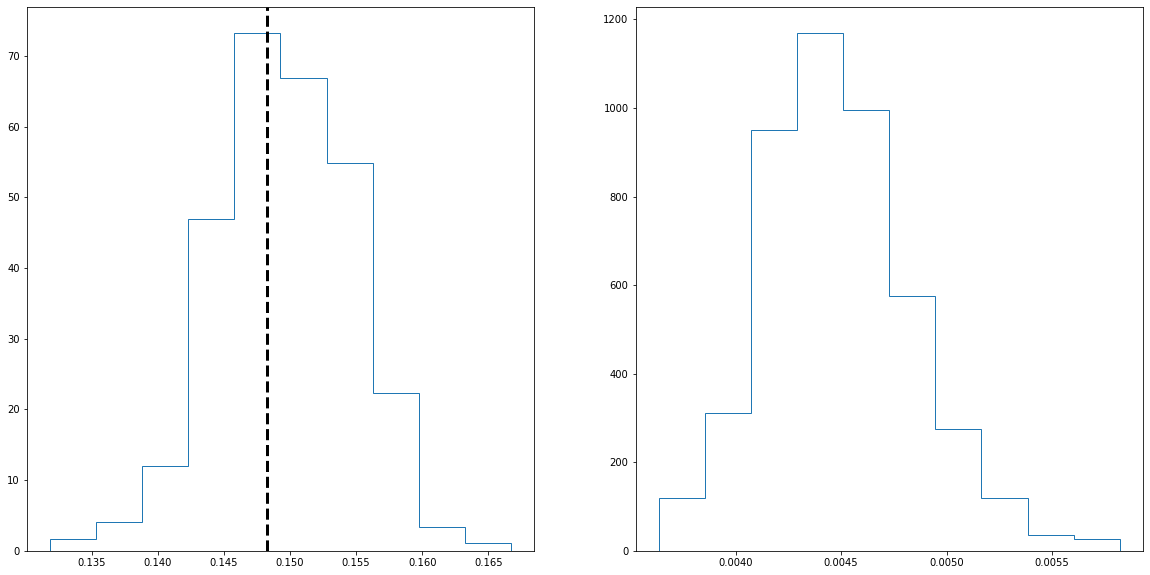

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.hist(all_MI_estimates[:, 0], density=True, histtype='step')
ax1.axvline(analytic, linewidth=3, c='k', linestyle='--')
ax2.hist(all_MI_estimates[:, 1], density=True, histtype='step');

### Dependence of bias and variance as a function of N

In [7]:
N_values = [1000, 2000, 5000, 10000, 20000, 50000]

random_states = 501
for N in N_values:
    results_file = f'./results/MI_{label}_{random_states}_{N}.npy'

    if os.path.isfile(results_file) :
        print('Not running this cell, since results file already exists. '
              'Loading pre-computed results...')
        all_MI_estimates = np.load(results_file)
    else:
        print(f'Estimating MI, and saving results...')
        all_MI_estimates = np.zeros((random_states, 2))

        # true GMM parameters
        n_components = dataset.n_components 
        true_weights = dataset.weights_
        true_means = dataset.means_
        true_covariances = dataset.covariances_

        for r in range(random_states):
            # create different realisation of ground truth; note the different random_state each time
            X = GMM(n_components=n_components, weights_init=true_weights, 
                              means_init=true_means, covariances_init=true_covariances, 
                              random_state=r).sample(N)[0]  

            mi_estimator = EstimateMI(gmm_fit_params=gmm_fit_params,
                                      select_components_params=select_components_params,
                                      mi_dist_params=mi_dist_params)
            MI_mean, MI_std = mi_estimator.fit(X)   

            all_MI_estimates[r, 0] = MI_mean
            all_MI_estimates[r, 1] = MI_std

            np.save(results_file, all_MI_estimates)
    print(N)

Not running this cell, since results file already exists. Loading pre-computed results...
1000
Not running this cell, since results file already exists. Loading pre-computed results...
2000
Not running this cell, since results file already exists. Loading pre-computed results...
5000
Not running this cell, since results file already exists. Loading pre-computed results...
10000
Not running this cell, since results file already exists. Loading pre-computed results...
20000
Not running this cell, since results file already exists. Loading pre-computed results...
50000


In [9]:
wrong_indices = [[ 72], [103], [145], [191], [500]]

N_values = [50000]

# parameters for every GMM fit that is being run
gmm_fit_params = GMMFitParamHolder(threshold_fit=1e-7,
                                   reg_covar=1e-12)

random_states = 501
for N in N_values:
    results_file = f'./results/MI_{label}_{random_states}_{N}.npy'

    all_MI_estimates = np.load(results_file)

    print(f'Estimating MI, and saving results...')
    all_MI_estimates = np.zeros((random_states, 2))

    # true GMM parameters
    n_components = dataset.n_components 
    true_weights = dataset.weights_
    true_means = dataset.means_
    true_covariances = dataset.covariances_

    for r in wrong_indices:
        r = r[0]
        # create different realisation of ground truth; note the different random_state each time
        X = GMM(n_components=n_components, weights_init=true_weights, 
                          means_init=true_means, covariances_init=true_covariances, 
                          random_state=r).sample(N)[0]  

        mi_estimator = EstimateMI(gmm_fit_params=gmm_fit_params,
                                  select_components_params=select_components_params,
                                  mi_dist_params=mi_dist_params, 
                                  verbose=True)
        MI_mean, MI_std = mi_estimator.fit(X)   
        print(MI_mean, MI_std)
        #all_MI_estimates[r, 0] = MI_mean
        #all_MI_estimates[r, 1] = MI_std

        #np.save(results_file, all_MI_estimates)
    print(N)

Estimating MI, and saving results...
Starting cross-validation procedure to select the number of GMM components...
Current number of GMM components: 1. Current metric: -2.401. Adding one component...
Current number of GMM components: 2. Current metric: -2.363. Adding one component...
Current number of GMM components: 3. Current metric: -2.250. Adding one component...
Metric change is less than threshold; patience counter increased by 1...
Reached patience limit, stop adding components.
Convergence reached at 3 GMM components.
Starting MI integral estimation...


100%|██████████| 100/100 [00:33<00:00,  2.99it/s]


MI estimation completed, returning mean and standard deviation.
0.14865648071587134 0.002219025576088045
Starting cross-validation procedure to select the number of GMM components...
Current number of GMM components: 1. Current metric: -2.396. Adding one component...
Current number of GMM components: 2. Current metric: -2.358. Adding one component...
Current number of GMM components: 3. Current metric: -2.249. Adding one component...
Metric change is less than threshold; patience counter increased by 1...
Reached patience limit, stop adding components.
Convergence reached at 3 GMM components.
Starting MI integral estimation...


100%|██████████| 100/100 [00:30<00:00,  3.25it/s]


MI estimation completed, returning mean and standard deviation.
0.1469000785784501 0.0022839390857057585
Starting cross-validation procedure to select the number of GMM components...
Current number of GMM components: 1. Current metric: -2.395. Adding one component...
Current number of GMM components: 2. Current metric: -2.353. Adding one component...
Current number of GMM components: 3. Current metric: -2.238. Adding one component...
Metric change is less than threshold; patience counter increased by 1...
Reached patience limit, stop adding components.
Convergence reached at 3 GMM components.
Starting MI integral estimation...


100%|██████████| 100/100 [00:32<00:00,  3.08it/s]


MI estimation completed, returning mean and standard deviation.
0.1465710473930778 0.0019629298664192193
Starting cross-validation procedure to select the number of GMM components...
Current number of GMM components: 1. Current metric: -2.403. Adding one component...
Current number of GMM components: 2. Current metric: -2.365. Adding one component...
Current number of GMM components: 3. Current metric: -2.248. Adding one component...
Metric change is less than threshold; patience counter increased by 1...
Reached patience limit, stop adding components.
Convergence reached at 3 GMM components.
Starting MI integral estimation...


100%|██████████| 100/100 [00:29<00:00,  3.36it/s]


MI estimation completed, returning mean and standard deviation.
0.14799317561730713 0.002169270274453768
Starting cross-validation procedure to select the number of GMM components...
Current number of GMM components: 1. Current metric: -2.398. Adding one component...
Current number of GMM components: 2. Current metric: -2.356. Adding one component...
Current number of GMM components: 3. Current metric: -2.242. Adding one component...
Metric change is less than threshold; patience counter increased by 1...
Reached patience limit, stop adding components.
Convergence reached at 3 GMM components.
Starting MI integral estimation...


100%|██████████| 100/100 [00:34<00:00,  2.94it/s]

MI estimation completed, returning mean and standard deviation.
0.14441455053869245 0.0019149499543147017
50000


In [11]:
wrong_indices = [[ 72], [103], [145], [191], [500]]

In [16]:
all_MI_estimates[72] = np.array([0.14865648071587134, 0.002219025576088045])

In [17]:
all_MI_estimates[103] = np.array([0.1469000785784501, 0.0022839390857057585])

In [18]:
all_MI_estimates[145] = np.array([0.1465710473930778, 0.0019629298664192193])

In [19]:
all_MI_estimates[191] = np.array([0.14799317561730713, 0.002169270274453768])

In [20]:
all_MI_estimates[500] = np.array([0.14441455053869245, 0.0019149499543147017])

In [24]:
#np.save(results_file, all_MI_estimates)